# Problem 4

## Q1

_Note: I am not standardizing the input._

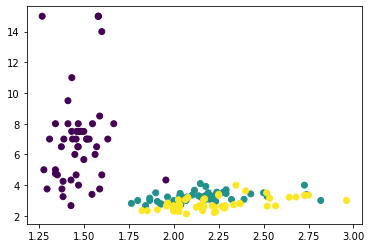

In [126]:
import math

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

%matplotlib inline

filename = 'iris-2.data'
data = pd.read_csv(filename, names=['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'class'])
data['sepal_ratio'] = data['sepal_length'] / data['sepal_width']
data['petal_ratio'] = data['petal_length'] / data['petal_width']
df = data.drop(['sepal_length', 'sepal_width', 'petal_length', 'petal_width'], axis=1)
df['class'], _ = pd.factorize(df['class'])
# df.head()

x = df['sepal_ratio']
y = df['petal_ratio']
df['color'] = df['class'].replace({
    'Iris-setosa': 'red',
    'Iris-versicolor': 'blue',
    'Iris-virginica': 'green'
})
plt.scatter(x, y, c=df['color'])

## Q2

In [127]:
from math import dist

from pandas import Series
np.random.seed(18)
df['coords'] = list(zip(x, y))

def dx2(coord1, centroid):
    # return np.sqrt((coord1[0] - centroid[0]) ** 2 + (coord1[1] - centroid[1]) ** 2)
    return (coord1[0] - centroid[0]) ** 2 + (coord1[1] - centroid[1]) ** 2

new_df = df[["sepal_ratio", "petal_ratio"]].to_numpy(dtype='float32')[:,:2]

#kmeans++ algorithm
def kpp_init(k):
    # Take one center
    _centroids = new_df[np.random.choice(df.shape[0], 1), :]

    for _ in range(k-1):
        dists = cdist(new_df, _centroids, 'euclidean')
        # for each point, get the closest centroid
        closest_cluster = np.min(dists, axis=1)
        # keep track of the furthest point from their closest centroid
        farthest_point = new_df[[np.argmax(closest_cluster)], :]
        # update _centroids
        _centroids = np.append(_centroids, farthest_point, axis=0)
    return _centroids

# noinspection PyPep8Naming
def kmeanspp_centroid(coords: Series, k):
    # Take one center
    # centroid = coords.sample().iloc[0]
    # _centroids = [centroid]
    _centroids = coords.sample()
    chosen = [_centroids.index[0]]

    # Take k-1 new centers with prob D(x)^2 / sum of D(x)^2
    # weights signify the prob distribution
    # while len(_centroids) < k:
    #     prob_dist = df['coords'].apply(dx2, args=(centroid,))
    #     centroid = df.sample(weights=prob_dist)['coords'].iloc[0]
    #     _centroids.append(centroid)

    while len(_centroids) < k:
        max_dist = -1
        farthest_point = None
        for index, coord in coords.items():
            # for each point, get the closest centroid
            closest_centroid = np.argmin([(coord[0] * centroid[0]) ** 2 + (coord[0] * centroid[0]) ** 2
                                         for centroid in _centroids])
            # print(f'{k=} index of closest cent={closest_centroid}')
            d = dist(coord, _centroids.iloc[closest_centroid])
            # keep track of the furthest point from their closest centroid
            if d > max_dist and index not in chosen:
                max_dist = d
                farthest_point = coord
                chosen.append(index)
        # update _centroids
        _centroids = pd.concat([_centroids, pd.Series([farthest_point], dtype=object)])

    return _centroids

# centroids = {}
# for _k in range(1, 6):
#     centroids[_k] = kmeanspp_centroid(df['coords'], _k)
# pprint(centroids)

## Q3

_Note: DBI score is used as the clustering objective._

k=2 dbi=0.34024794906992745
k=3 dbi=0.25177597158316023
k=4 dbi=0.47653943938097953
k=5 dbi=0.5566814573344967


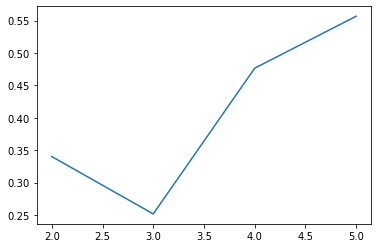

In [128]:
from scipy.spatial.distance import cdist
from sklearn.metrics import davies_bouldin_score
%matplotlib inline

feature_df = pd.concat([x, y], axis=1)


# def update_centroids(_df, centers, _centroids):
#     sums = {}
#     n = len(centers)
#     for i in range(n):
#         coords = _df.iloc[i]['coords']
#         center = centers[i]
#         if center not in sums:
#             sums[center] = (0, 0)
#         sums[center] = (coords[0] + sums[center][0], coords[1] + sums[center][1])
#     for i, _sum in sums.items():
#         _centroids.iloc[i] = (_sum[0] / n, _sum[1] / n)
#     return _centroids


def dist2(coords, _centroids):
    dists = [math.dist(coords, centroid) for centroid in _centroids]
    return dists


def kmeans(k, break_early=True):
    scores = []
    # centroids = kmeanspp_centroid(df['coords'], k)
    centroids = kpp_init(k)

    distances = df['coords'].apply(dist2, args=(centroids,))
    points = np.array([np.argmin(d) for d in distances])
    df['centers'] = points

    for _ in range(50):
        prev_points = points
        centroids = []
        for idx in range(k):
            filtered_df = df[df['centers'] == idx]
            if len(filtered_df) == 0:
                print('dead')
            cent_x = filtered_df['sepal_ratio'].mean(axis=0)
            cent_y = filtered_df['petal_ratio'].mean(axis=0)
            centroids.append((cent_x, cent_y))
        centroids = np.vstack(centroids)
        distances = df['coords'].apply(dist2, args=(centroids,))
        points = np.array([np.argmin(d) for d in distances])

        if not break_early:
            # For plotting, we need scores for all iterations
            score = davies_bouldin_score(feature_df, points)
            scores.append(score)
        elif np.array_equal(points, prev_points):
            # Otherwise, we're only interested in the final score
            # print(f'Finished after {i} iterations')
            break

    # print(f'{k=} centers={pd.unique(points)}')
    dbi = davies_bouldin_score(feature_df, points)
    print(f'{k=} {dbi=}')

    return dbi, scores, points, centroids

    # prev = pd.Series(dtype=int)
    # centers = pd.Series(dtype=int)
    # for i in range(50):
    #     # print(centroids[k])
    #     centers = df['coords'].apply(dist2, args=(centroids,))
    #     print(f'{k=} centers={pd.unique(centers)}')
    #     centroids = update_centroids(df, centers, centroids)
    #     if prev.equals(centers):
    #         # print(f'{i=} {prev=} {centers=}')
    #         print(f'Finished in {i} iterations')
    #         break
    #     prev = centers
    #
    # print(f'{k=} centers={pd.unique(centers)}')
    # scores[k] = davies_bouldin_score(feature_df, centers)
    # print(f'{k=} accuracy={scores[k]}')
#
#     # cmap = {
#     #     0: 'purple',
#     #     1: 'red',
#     #     2: 'green',
#     #     3: 'blue',
#     #     4: 'orange',
#     # }
#     # df['color'] = centers.replace(cmap)
#     # # df[df['coords'] in centroids[k]]['color'] = 'black'
#     # plt.scatter(x, y, c=df['color'])
#     # plt.show()
#
#     # accuracy = accuracy_score(df['class'], centers)
#     # print(f'{k=} {accuracy=}')
#

_x = []
_y = []
for i in range(2, 6):
    acc, _, _, _ = kmeans(k=i)
    _x.append(i)
    _y.append(acc)

plt.plot(_x, _y)

# Q4

* Cluster size of 3 was chosen as the DBI score for $k=3$ was the lowest. This is expected since the original dataset also has 3 clusters, thus our algorithm is correctly guessing the optimum number of clusters to some extent.

k=3 dbi=0.2569306928383754


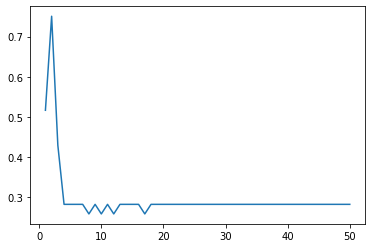

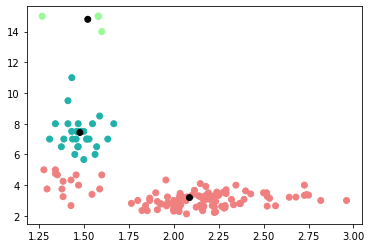

In [130]:
clusters = 3
_, scores, centers, coords = kmeans(clusters, break_early=False)
# scores = dbis
_x = range(1, 51)
_y = scores

colors = []
all_colors = ['lightcoral', 'palegreen', 'lightseagreen', 'hotpink', 'orange']
for i, center in enumerate(centers):
    colors.append(all_colors[center])

plt.plot(_x, _y); plt.show()

_x = np.array(x)
_y = np.array(y)
for coord in coords:
    _x = np.append(_x, coord[0])
    _y = np.append(_y, coord[1])
    colors.append('black')
# plt.xlim(0, 14)
plt.scatter(_x, _y, c=colors)

* Accuracy doesn't really change with number of iterations because:
    * K-means is converging right at the beginning.
    * Since, we are using kmeans++ for choosing our initial centroids, we choose good points right at the start, so the accuracy doesn't really change much compared to the beginning.